In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
from models import DNMC, NMC, NSurv, MLP

tf.random.set_seed(2021)

In [2]:
from sklearn.datasets import make_moons, make_circles

x0, e0 = make_moons(n_samples=40000, noise=.5, random_state=0)
x1, e1 = make_circles(n_samples=40000, noise=.5, factor=.5, random_state=0)
x2 = np.random.randn(40000, 1)
x = np.concatenate([x0, x1, x2], axis=1)
e = np.concatenate([e0[:, np.newaxis], e1[:, np.newaxis]], axis=1)
x = x - np.mean(x, axis=0)

max_time = 3

xmu_coeffs = np.array([[0., 0., 0., 0., 1.], [0., 0., 0., 0., -1.]]).T
mu_event = np.squeeze((x @ xmu_coeffs)) + .3
sig_event = .25 * np.random.randn(40000, 2)

t = np.exp(mu_event + sig_event * np.random.randn(40000, 2))
c = max_time * np.random.rand(40000, 2)

y = np.minimum(t, c)
s = (y == t).astype(int)

In [3]:
# we will just use the first event (make moons)

e = e[:, 0]
t = t[:, 0]
c = c[:, 0]
y = y[:, 0]
s = s[:, 0]

NBINS = 25

def discretize(arr, nbins=10, pad=1e-5, min_val=None, max_val=None):
    min_val = min_val or np.amin(arr)
    max_val = max_val or np.amax(arr)
    binsize = (max_val - min_val + pad) / nbins
    return (arr - arr.min()) // binsize
    
def onehot(arr, ncategories=None):
    if ncategories is None:
        ncategories = len(np.unique(arr))
    return np.eye(ncategories)[arr.astype(int)]

y_disc = discretize(y, nbins=NBINS)
y_onehot = onehot(y_disc, ncategories=NBINS)

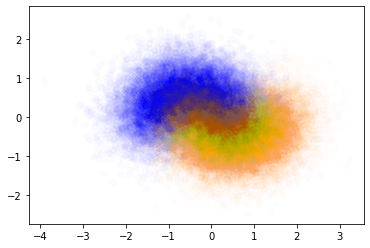

In [4]:
plt.scatter(x[e == 0, 0], x[e == 0, 1], c='blue', alpha=0.01)
plt.scatter(x[e == 1, 0], x[e == 1, 1], c='orange', alpha=0.01)
plt.show()

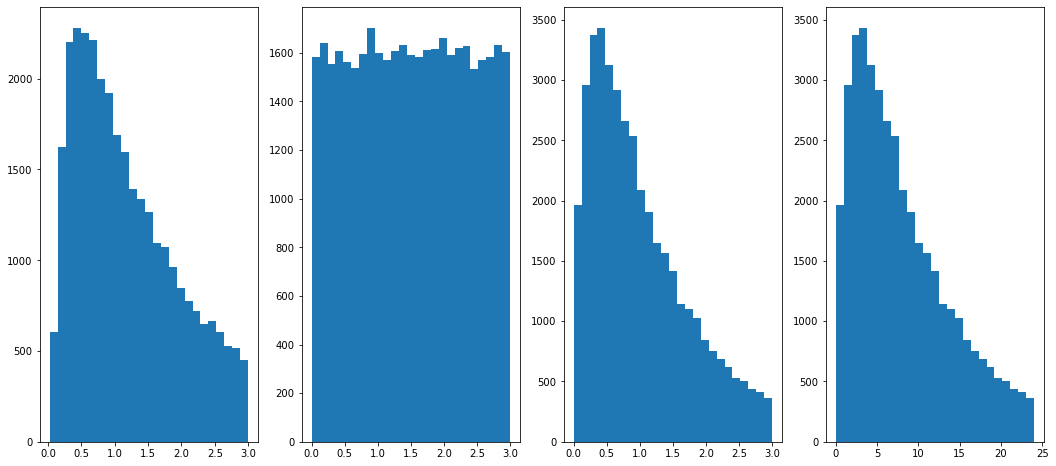

In [5]:
# visualize event times

fig, ax = plt.subplots(1, 4, figsize=(18, 8))

ax[0].hist(t[t < 3], bins=25)
ax[1].hist(c, bins=25)
ax[2].hist(y, bins=25)
ax[3].hist(y_disc, bins=25)

plt.show()

In [6]:
val_idx = 3 * len(x) // 5
test_idx = 4 * len(x) // 5

x_train = x[:val_idx]
y_train = y_onehot[:val_idx]
s_train = s[:val_idx]
e_train = e[:val_idx]

x_val = x[val_idx:test_idx]
y_val = y_onehot[val_idx:test_idx]
s_val = s[val_idx:test_idx]
e_val = e[val_idx:test_idx]

x_test = x[test_idx:]
y_test = y_onehot[test_idx:]
s_test = s[test_idx:]
e_test = e[test_idx:]

In [7]:
def get_batches(*arrs, batch_size=1):
    l = len(arrs[0])
    for ndx in range(0, l, batch_size):
        yield (arr[ndx:min(ndx + batch_size, l)] for arr in arrs)
        
import time

def train_model(
    model, train_data, val_data, n_epochs,
    batch_size=50, learning_rate=1e-3, early_stopping_criterion=2):

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    #@tf.function
    def train_step(x, y, s):
        with tf.GradientTape() as tape:
            train_loss, train_nll = model.loss(x, y, s)
            #print(train_loss, train_nll)
        grads = tape.gradient(train_loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        return train_loss, train_nll

    #@tf.function
    def test_step(x, y, s):
        val_loss, val_nll = model.loss(x, y, s)
        return val_loss, val_nll
    
    best_val_loss = np.inf
    no_decrease = 0

    for epoch_idx in range(n_epochs):

        #print("\nStart of epoch %d" % (epoch_idx,))
        start_time = time.time()

        train_losses = []
        train_nlls = []

        for batch_idx, (xt, yt, st) in enumerate(get_batches(*train_data, batch_size=batch_size)):

            train_loss, train_nll = train_step(xt, yt, st)

            train_losses.append(train_loss)
            train_nlls.append(train_nll)

        # Display metrics at the end of each epoch.
        #print('Epoch training loss: %.4f, NLL = %.4f' % (np.mean(batch_losses), np.mean(batch_nll)))

        val_losses = []
        val_nlls = []

        # Run a validation loop at the end of each epoch.
        for batch_idx, (xv, yv, sv) in enumerate(get_batches(*val_data, batch_size=batch_size)):

            val_loss, val_nll = test_step(xv, yv, sv)

            val_losses.append(val_loss)
            val_nlls.append(val_nll)
            
        new_val_loss = np.mean(val_losses)

        print(
            'Epoch %2i | Train Loss: %.4f | Train NLL: %.4f | Val Loss: %.4f | Val NLL: %.4f'
            % (epoch_idx, np.mean(train_losses), np.mean(train_nlls), np.mean(val_losses), np.mean(val_nlls))
        )
        #print('Time taken: %.2fs' % (time.time() - start_time))
                
        if new_val_loss > best_val_loss:
            no_decrease += 1
        else:
            no_decrease = 0
            best_val_loss = new_val_loss
            
        if no_decrease == early_stopping_criterion:
            break

In [8]:
from sklearn.metrics import roc_auc_score


def nll(t_true, t_pred, tol=1e-8):
    ncat = np.shape(t_pred)[1]
    nll_ = -1 * np.log(np.sum(onehot(t_true, ncategories=ncat) * t_pred, axis=1) + tol)
    return np.mean(nll_)


def evaluate_model(
    model, test_data, e_test, 
    batch_size=50, dataset='support', factors='unknown'):
    
    modelname = type(model).__name__
    
    test_losses = []
    test_nlls = []
    
    test_e_pred = []
    test_t_pred = []
    test_c_pred = []
    
    for batch_idx, (xt, yt, st) in enumerate(get_batches(*test_data, batch_size=batch_size)):
        
        test_loss, test_nll = model.loss(xt, yt, st)
        
        if modelname == 'NSurv':
            t_pred, c_pred = model(xt)
            test_t_pred.append(t_pred)
            test_c_pred.append(c_pred)
        elif modelname == 'MLP':
            e_pred = model(xt)
            test_e_pred.append(e_pred)
        else:
            e_pred, t_pred, c_pred = model(xt)
            test_e_pred.append(e_pred)
            test_t_pred.append(t_pred)
            test_c_pred.append(c_pred)
        
        test_losses.append(test_loss)
        test_nlls.append(test_nll)
    
    if modelname == 'NSurv':
        e_auc = None
    else:
        e_auc = roc_auc_score(e_test, np.concatenate(test_e_pred, axis=0))
        
    if modelname == 'MLP':
        t_nll = None
        c_nll = None
    else:
        t_nll = None
        c_nll = None
    
    results = {
        'dataset': dataset,
        'factors': factors,
        'model': modelname,
        'ld': model.ld,
        'lr': model.lr,
        'avg_test_loss': np.mean(test_losses),
        'avg_test_nll': np.mean(test_nlls),
        'e_auc': e_auc,
        't_nll': t_nll,
        'c_nll': c_nll
    }
    
    return results

In [9]:
# Run NMC Model

model = NMC(
    e_layer_sizes=(50,),
    t_layer_sizes=(50,),
    n_bins=NBINS
)

train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 50, learning_rate=1e-3)
evaluate_model(model, (x_test, y_test, s_test), e_test)

Epoch  0 | Train Loss: 3.3788 | Train NLL: 3.2848 | Val Loss: 3.0935 | Val NLL: 3.0569
Epoch  1 | Train Loss: 2.9958 | Train NLL: 2.9620 | Val Loss: 2.9340 | Val NLL: 2.9002
Epoch  2 | Train Loss: 2.8925 | Train NLL: 2.8573 | Val Loss: 2.8678 | Val NLL: 2.8312
Epoch  3 | Train Loss: 2.8460 | Train NLL: 2.8083 | Val Loss: 2.8341 | Val NLL: 2.7954
Epoch  4 | Train Loss: 2.8216 | Train NLL: 2.7823 | Val Loss: 2.8149 | Val NLL: 2.7750
Epoch  5 | Train Loss: 2.8071 | Train NLL: 2.7670 | Val Loss: 2.8026 | Val NLL: 2.7623
Epoch  6 | Train Loss: 2.7974 | Train NLL: 2.7571 | Val Loss: 2.7942 | Val NLL: 2.7538
Epoch  7 | Train Loss: 2.7905 | Train NLL: 2.7504 | Val Loss: 2.7880 | Val NLL: 2.7480
Epoch  8 | Train Loss: 2.7852 | Train NLL: 2.7456 | Val Loss: 2.7832 | Val NLL: 2.7437
Epoch  9 | Train Loss: 2.7810 | Train NLL: 2.7420 | Val Loss: 2.7793 | Val NLL: 2.7405
Epoch 10 | Train Loss: 2.7775 | Train NLL: 2.7392 | Val Loss: 2.7761 | Val NLL: 2.7381
Epoch 11 | Train Loss: 2.7746 | Train NLL: 

{'dataset': 'support',
 'factors': 'unknown',
 'model': 'NMC',
 'ld': 0.001,
 'lr': 0.001,
 'avg_test_loss': 2.7624025,
 'avg_test_nll': 2.7406564,
 'e_auc': 0.4853940084281382,
 't_nll': None,
 'c_nll': None}

In [10]:
e_pred, t_pred, c_pred = (arr.numpy() for arr in model(x_test))

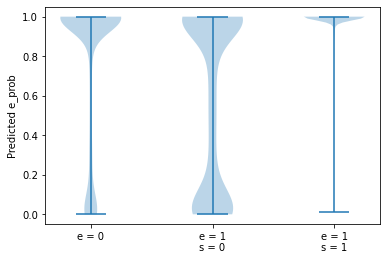

In [11]:
# Visualize CFT Predictions

plt.violinplot([e_pred[e_test == 0], e_pred[(e_test == 1) & (s_test == 0)], e_pred[s_test == 1]])
plt.xticks([1, 2, 3], ['e = 0', 'e = 1\ns = 0', 'e = 1\ns = 1'])
plt.ylabel('Predicted e_prob')

plt.show()

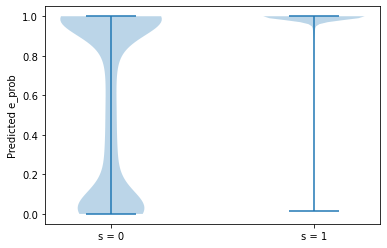

In [12]:
# Visualize CFT Predictions

plt.violinplot([e_pred[s_test == 0], e_pred[s_test == 1]])
plt.xticks([1, 2], ['s = 0', 's = 1'])
plt.ylabel('Predicted e_prob')

plt.show()

In [13]:
# Run NMC Model

model = DNMC(
    phi_layer_sizes=(50,),
    psi_layer_sizes=(50,),
    omega_layer_sizes=(50,),
    e_layer_sizes=(50,),
    t_layer_sizes=(50,),
    c_layer_sizes=(50,),
    n_bins=NBINS
)

In [14]:
model.loss(x_train[:50], y_train[:50], s_train[:50])

(<tf.Tensor: shape=(), dtype=float32, numpy=4.04277>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.8143096>)

In [15]:
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 50, learning_rate=1e-4)
evaluate_model(model, (x_test, y_test, s_test), e_test)

Epoch  0 | Train Loss: 3.8066 | Train NLL: 3.5913 | Val Loss: 3.6216 | Val NLL: 3.4175
Epoch  1 | Train Loss: 3.5108 | Train NLL: 3.3153 | Val Loss: 3.4215 | Val NLL: 3.2340
Epoch  2 | Train Loss: 3.3523 | Train NLL: 3.1714 | Val Loss: 3.2996 | Val NLL: 3.1248
Epoch  3 | Train Loss: 3.2475 | Train NLL: 3.0779 | Val Loss: 3.2134 | Val NLL: 3.0488
Epoch  4 | Train Loss: 3.1735 | Train NLL: 3.0135 | Val Loss: 3.1519 | Val NLL: 2.9962
Epoch  5 | Train Loss: 3.1196 | Train NLL: 2.9679 | Val Loss: 3.1060 | Val NLL: 2.9581
Epoch  6 | Train Loss: 3.0784 | Train NLL: 2.9340 | Val Loss: 3.0702 | Val NLL: 2.9292
Epoch  7 | Train Loss: 3.0457 | Train NLL: 2.9077 | Val Loss: 3.0413 | Val NLL: 2.9063
Epoch  8 | Train Loss: 3.0188 | Train NLL: 2.8865 | Val Loss: 3.0171 | Val NLL: 2.8873
Epoch  9 | Train Loss: 2.9964 | Train NLL: 2.8690 | Val Loss: 2.9967 | Val NLL: 2.8715
Epoch 10 | Train Loss: 2.9773 | Train NLL: 2.8542 | Val Loss: 2.9791 | Val NLL: 2.8579
Epoch 11 | Train Loss: 2.9611 | Train NLL: 

{'dataset': 'support',
 'factors': 'unknown',
 'model': 'DNMC',
 'ld': 0.001,
 'lr': 0.001,
 'avg_test_loss': 2.8474503,
 'avg_test_nll': 2.7789645,
 'e_auc': 0.4975386836541932,
 't_nll': None,
 'c_nll': None}